 Proyek NLP: **BBC Text Dataset**
- Nama:**ERIKA BUDIARTI**
- Email: erika.analytic@gmail.com
- Id Dicoding:erika_budiarti


# **Import Library**

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dropout, Dense, LSTM, MaxPooling1D, Conv1D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Load Dataset

In [2]:
bbc_df = pd.read_csv('/content/bbc-text.csv')

In [3]:
bbc_df.shape

(2225, 2)

In [4]:
bbc_df.sample(10)

,category,text
658,sport,kirwan demands italy consistency italy coach j...
189,entertainment,grammys honour soul star charles the memory of...
1857,politics,parliament s record of scandal in a locked roo...
1123,business,qantas sees profits fly to record australian a...
534,politics,scots smoking ban details set out smoke-free a...
1879,tech,file-swappers ready new network legal attacks ...
2117,sport,wales stars need a rest - ruddock wales coach ...
520,business,fiat chief takes steering wheel the chief exec...
49,business,stock market eyes japan recovery japanese shar...
489,business,cairn shares slump on oil setback shares in ca...


In [5]:
bbc_df.isna().sum()

category    0
text        0
dtype: int64

In [6]:
bbc_df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [7]:
# Melakukan One-Hot encoding
category = pd.get_dummies(bbc_df.category)
bbc_new = pd.concat([bbc_df, category], axis=1)
bbc_new = bbc_new.drop(columns='category')
bbc_new.reset_index(inplace=True, drop=True)
bbc_new.shape

(2225, 6)

In [8]:
bbc_new.sample(10)

,text,business,entertainment,politics,sport,tech
1862,johnson uncertain about euro bid jade johnson ...,0,0,0,1,0
1649,us trade gap ballooned in october the us trade...,1,0,0,0,0
727,anti-spam laws bite spammer hard the net s sel...,0,0,0,0,1
160,goodrem wins top female mtv prize pop singer d...,0,1,0,0,0
193,french suitor holds lse meeting european stock...,1,0,0,0,0
844,why cell will get the hard sell the world is c...,0,0,0,0,1
36,gamers snap up new sony psp gamers have bought...,0,0,0,0,1
1473,bmw to recall faulty diesel cars bmw is to rec...,1,0,0,0,0
1982,the gaming world in 2005 if you have finished ...,0,0,0,0,1
1140,film star fox behind theatre bid leading actor...,0,1,0,0,0


# **Penggunaan Stopwords**

In [9]:
nltk.download('stopwords')
STOPWORDS = set(stopwords.words())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
texts = []
categories = []

for index, row in bbc_df.iterrows():
    categories.append(row['category'])
    text = row['text']
    for word in STOPWORDS:
        token = ' ' + word + ' '
        text = text.replace(token, ' ')
        text = text.replace(' ', ' ')
    texts.append(text)

# **Split Dataset**

In [11]:
X_train, X_val, y_train, y_val = train_test_split(texts, categories, test_size=0.2, random_state=42)

# **Penggunaan Tokenizer**

In [12]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [13]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=200, padding='post', truncating='post')

val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences, maxlen=200, padding='post', truncating='post')

In [14]:
categories_tokenizer = Tokenizer()
categories_tokenizer.fit_on_texts(categories)

In [15]:
train_catseq = np.array(categories_tokenizer.texts_to_sequences(y_train))
val_catseq = np.array(categories_tokenizer.texts_to_sequences(y_val))

# **Pembuatan Model**

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 64, input_length=200),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences=True)),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 64)           640000    
                                                                 
 bidirectional (Bidirection  (None, 200, 64)           24832     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 64)           24832     
 onal)                                                           
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           20544     
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 64)            0         
 D)                                                              
                                                        

In [18]:
loss = SparseCategoricalCrossentropy()

In [19]:
optimizer = RMSprop()

In [20]:
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [21]:
class iCallback(tf.keras.callbacks.Callback):
  def __init__(self, model):
    self.model = model

  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('val_accuracy') >= 0.91 and
        logs.get('accuracy') >= 0.91):
        self.model.stop_training = True

callback_model = iCallback(model)


In [22]:
history = model.fit(
    train_padded,
    train_catseq,
    epochs=20,
    batch_size=32,
    validation_data=(val_padded, val_catseq),
    callbacks=[callback_model],
    verbose=2
)

Epoch 1/20
56/56 - 33s - loss: 1.3068 - accuracy: 0.4180 - val_loss: 0.9806 - val_accuracy: 0.5798 - 33s/epoch - 585ms/step
Epoch 2/20
56/56 - 23s - loss: 0.5239 - accuracy: 0.7927 - val_loss: 0.4311 - val_accuracy: 0.8449 - 23s/epoch - 414ms/step
Epoch 3/20
56/56 - 24s - loss: 0.2020 - accuracy: 0.9292 - val_loss: 0.3556 - val_accuracy: 0.8854 - 24s/epoch - 435ms/step
Epoch 4/20
56/56 - 22s - loss: 0.0638 - accuracy: 0.9803 - val_loss: 0.3183 - val_accuracy: 0.9101 - 22s/epoch - 391ms/step


# **Accuracy & Loss Plot**

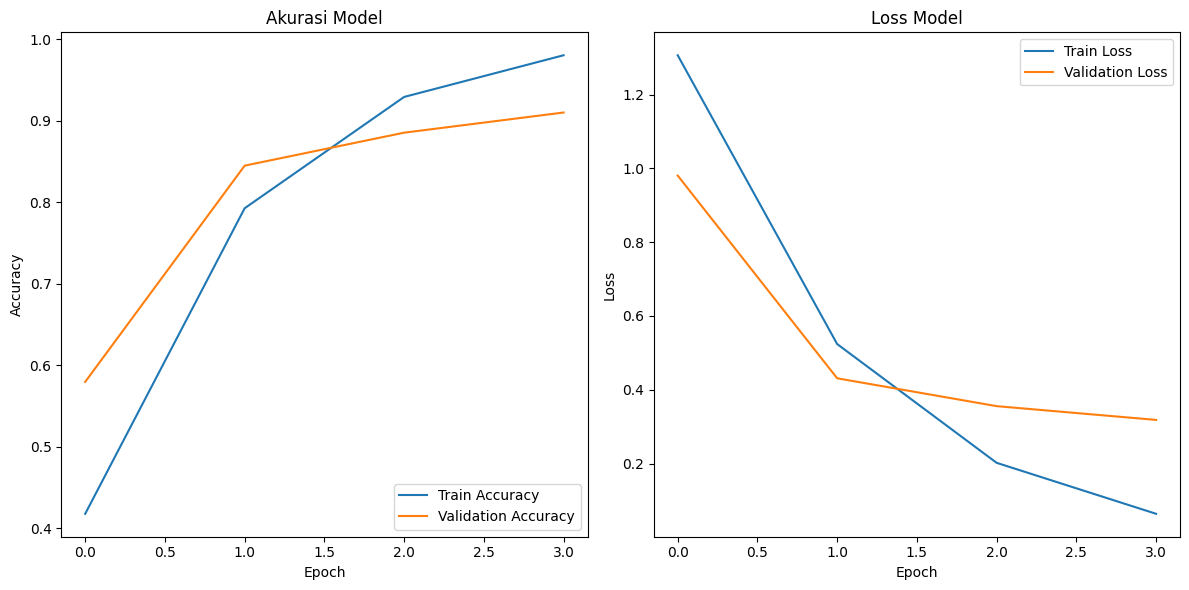

In [23]:
import matplotlib.pyplot as plt

# Data akurasi
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Data loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot pertama (Akurasi)
axes[0].plot(train_accuracy, label='Train Accuracy')
axes[0].plot(val_accuracy, label='Validation Accuracy')
axes[0].set_title('Akurasi Model')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

# Plot kedua (Loss)
axes[1].plot(train_loss, label='Train Loss')
axes[1].plot(val_loss, label='Validation Loss')
axes[1].set_title('Loss Model')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()